# Проектная работа

## Тема: Анализ бизнес-показателей

### Описание проекта:
Необходимо выступить в роли маркетингового аналитика развлекательного приложения Procrastinate Pro+ и выяснить почему последние несколько месяцев компания терпит убытки, не смотря на огромные вложения в рекламу.

Задача — разобраться в причинах и помочь компании выйти в плюс.
Предстоит анализировать информацию о пользователях, привлечённых с 1 мая по 27 октября 2019 года. Для этого были выгружены следующие отчеты:
- лог сервера с данными о посещениях пользователей (файл - visits_info_short.csv),
- выгрузка их покупок за этот период (файл - orders_info_short.csv),
- рекламные расходы с 1 мая по 27 октября 2019 года (файл - costs_info_short.csv).

In [1]:
# импортируем библиотеки, которые могут быть использованы в дальнейшем анализе
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

##  1. Откроем файлы с данными и изучим общую информацию

In [2]:
# функция, которая выдает основную информацию о датафрейме
def info_df(data):
    display(
          data.info(),  
          data.isna().sum(), 
          data.duplicated().sum()
         ) 

In [3]:
# данные о пользователях сохраним в ДФ users
users = pd.read_csv('/Users/uliabubnova/Downloads/visits_info_short.csv')

# выведем первые 5 строк ДФ
display(users.head())

# выведем общую информацию о ДФ, наличие пропусков и дубликатов
info_df(users)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

0

В первом датафрейме около 310 тыс строк и 6 столбцов. Пропусков данных и явных дубликатов нет, но есть несоответсвие типов данных (даты храняться в строковом типе). Также стоит переименовать названия столбцов (привести их общепринятому стилю snake_case)

In [4]:
# преобразуем названия столбцов
users.columns = users.columns.str.lower().str.replace(' ', '_')

In [5]:
# приведем даты к типу datetime
users['session_start'] = pd.to_datetime(users['session_start'])
users['session_end'] = pd.to_datetime(users['session_end'])

Преобразование типа прошло без ошибок, значит "строковые даты" были реалистичными. Убедимся, что данные в остальных столбцах имеют корректные значения.

In [6]:
# узнаем, есть ли неположительные знчения в столбце user_id
len(users.query('user_id <=0')['user_id'].unique())

0

In [7]:
# рассмотрим, какие значения страны, устройства и каналов продвижения есть в ДФ
for column in ['region', 'device', 'channel']:
    print(users[column].unique())


['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


Все значения выглядят реалистичными, аномалий и неккоректных данных не выявлено. Еще раз выведим общую информацию о ДФ, чтобы убедиться, что переименование столбцов и изменение типов прошло корректно.

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [9]:
# загрузим данные с заказами пользователей в ДФ revenues
try:
    revenues = pd.read_csv('/Users/uliabubnova/Downloads/orders_info_short.csv')
except:
    revenues = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
display(revenues.head())
info_df(revenues)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

User Id     0
Event Dt    0
Revenue     0
dtype: int64

0

В ДФ более 40 тыс строк, нет пропусков и дубликатов, но даты опять записаны строками и названия столбцов не приведено к стандарту. Изменим это.

In [10]:
# переименуем столбцы и изменим тип дат
revenues.columns = revenues.columns.str.lower().str.replace(' ', '_')
revenues['event_dt'] = pd.to_datetime(revenues['event_dt'])

In [11]:
# узнаем, есть ли неположительные знчения в столбце user_id
print(len(revenues.query('user_id <=0')['user_id'].unique()))
len(revenues.query('revenue <=0')['revenue'].unique())

0


0

Неположительных значений в идентификаторах пользователей и суммах заказов не найдено.

In [12]:
# проверим внесенные изменения
revenues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [13]:
# в ДФ costs занесем данные из файла с маркетинговыми расходами
try:
    costs = pd.read_csv('/Users/uliabubnova/Downloads/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
display(costs.head())
info_df(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

dt         0
Channel    0
costs      0
dtype: int64

0

Имеем 1800 строк. Проведем аналогичные изменения: сменим стиль написания названий столбцов и тип дат, а также проверим наполнение столбца `channel` на реалистичность

In [14]:
costs.columns = costs.columns.str.lower().str.replace(' ', '_')
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Проверим за какой период выгружены данные по рекламным расходам, ведь именно по временному периоду из этой таблицы в дальнейшем будут сформированы профили пользователей.

In [16]:
print(costs['dt'].min(), costs['dt'].max())

2019-05-01 2019-10-27


Даты как раз совпадат с требуемым периодом для анализа

### Итоги предобработки:
- выгруженные для анализа данные были хорошего качества: отсутсвуют пропуски и дубликаты, все значения реалистичные 
- названия полей привели к стандарту snake_case
- типы дат были приведены к datetime


## 2. Объявим функции для расчёта и анализа LTV, ROI, удержания и конверсии, а также построения графиков

In [17]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## 3. Исследовательский анализ данных

Сформируем профили пользователей и определим самые ранние и поздние даты сессий для каждого из них

In [25]:
profiles = get_profiles(users, revenues, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [26]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print('Самая ранняя дата: {}'.format(min_date), \
      'Самая поздняя дата: {}'.format(max_date), sep='\n')

Самая ранняя дата: 2019-05-01
Самая поздняя дата: 2019-10-27


Хорошая новость - в сводной таблице профилей пользователей крайнее даты периода совпадат с оговоренными в первональном условии. 

### Создадим функцию, которая будет группировать пользователей по определенному параметру и расчитывать количество и долю платящих пользователей

In [27]:
def get_grouped(data, column):
    # определим общее количество новых пользователей в каждой группе
    profiles_grouped = data.groupby(column)\
    .agg({'user_id':'nunique'}).reset_index()
    
    # определим, сколько платящих пользователей в каждой группе
    profiles_grouped_payer = data.query('payer==True').groupby(column)\
    .agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id': 'user_id_payer'})

    display(profiles_grouped.sort_values(by='user_id', ascending=False))
    display(profiles_grouped_payer.sort_values(by='user_id_payer', ascending=False))

    # создадим общую таблицу и расчитаем долю платящих клиентов в каждой группе
    profiles_merge=profiles_grouped.merge(profiles_grouped_payer, on=column)
    profiles_merge['users_payer_%'] = profiles_merge['user_id_payer']\
    /profiles_merge['user_id']*100
    profiles_merge = profiles_merge.sort_values(by='users_payer_%', ascending=False)
    return profiles_merge


### 1. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [28]:
users_country = get_grouped(profiles, 'region')
users_country

,region,user_id
3,United States,100002
2,UK,17575
0,France,17450
1,Germany,14981


,region,user_id_payer
3,United States,6902
2,UK,700
0,France,663
1,Germany,616


,region,user_id,user_id_payer,users_payer_%
3,United States,100002,6902,6.901862
1,Germany,14981,616,4.111875
2,UK,17575,700,3.982930
0,France,17450,663,3.799427


- Две трети всех новых пользователей приложения - это американцы. При этом доля американцев среди платящих пользователей уже 78%
- Примерно 7 пользователей из 100 совершают покупку в Америке. В Европейских странах этот показатель значительно ниже, в среднем только 4 пользователя платит деньги в приложении.
- Из Европейских стран пользователи из Германии охотнее других совершают покупки

### 2. Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [29]:
users_device = get_grouped(profiles, 'device')
users_device

,device,user_id
3,iPhone,54479
0,Android,35032
2,PC,30455
1,Mac,30042


,device,user_id_payer
3,iPhone,3382
0,Android,2050
1,Mac,1912
2,PC,1537


,device,user_id,user_id_payer,users_payer_%
1,Mac,30042,1912,6.364423
3,iPhone,54479,3382,6.207897
0,Android,35032,2050,5.851793
2,PC,30455,1537,5.046790


- Чаще всего в приложение заходят с мобильного телефона, при чем в большинстве случаев это iPhone
- Интересный факт, что несмотря на то, что чаще всего в приложение заходят с мобильного телефона, но пользователи Mac совершают покупки охотнее. 
- `Заметка для отдела маркетинга: Стоит сравнить удобство и интерфейс приложения для различных устройств. Возможно, для Mac и iPhone "подведение клиента к оплате" организовано более качественно, чем для других устройств?`


### 3. Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [30]:
users_channel = get_grouped(profiles, 'channel')
users_channel

,channel,user_id
10,organic,56439
1,FaceBoom,29144
6,TipTop,19561
4,OppleCreativeMedia,8605
2,LeapBob,8553
7,WahooNetBanner,8553
5,RocketSuperAds,4448
3,MediaTornado,4364
8,YRabbit,4312
0,AdNonSense,3880


,channel,user_id_payer
1,FaceBoom,3557
6,TipTop,1878
10,organic,1160
7,WahooNetBanner,453
0,AdNonSense,440
5,RocketSuperAds,352
2,LeapBob,262
4,OppleCreativeMedia,233
9,lambdaMediaAds,225
8,YRabbit,165


,channel,user_id,user_id_payer,users_payer_%
1,FaceBoom,29144,3557,12.204914
0,AdNonSense,3880,440,11.340206
9,lambdaMediaAds,2149,225,10.469986
6,TipTop,19561,1878,9.600736
5,RocketSuperAds,4448,352,7.913669
7,WahooNetBanner,8553,453,5.296387
8,YRabbit,4312,165,3.826531
3,MediaTornado,4364,156,3.574702
2,LeapBob,8553,262,3.063253
4,OppleCreativeMedia,8605,233,2.707728


- Самую высокую конверсию показывают следующие каналы: FaceBoom, AdNonSense, lambdaMediaAds, TipTop и 	RocketSuperAds.
- Значителья доля пользователей приходит в приложение органическим путем. Конечно, у них самая низкая конверсия покупок, но за счет количества, они входят в тройку лидеров по количеству покупок среди всех каналов привлечения. Это хороший показатель, вель все эти пользователи являются "бесплатными" для нашей компании.
- Помимо лидера по привлечению FaceBoom, выделяются два очень перспективных канала: AdNonSense и lambdaMediaAds - через них приходит не так много клиентов, но зато привлекаются более качественные пользователи (в 10-11% совершающие покупку)

## 4. Маркетинг

In [31]:
# исключим из ДФ profiles всех органических пользователей
profiles = profiles.query('channel != "organic"')

Посчитаем общую сумму расходов на маркетинг и выясним, как траты распределены по рекламным источникам

In [32]:
print('Общие траты на маркетинг c 1 мая по 27 октября 2019:', costs['costs'].sum(), '$')

Общие траты на маркетинг c 1 мая по 27 октября 2019: 105497.30000000002 $


### 1. Выясните, как траты распределены по рекламным источникам.

In [33]:
costs_grouped = profiles.groupby('channel').agg({'acquisition_cost': 'sum'})\
.sort_values(by='acquisition_cost', ascending=False).reset_index()

costs_grouped

,channel,acquisition_cost
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


`Вот первая зацепка:` больше половины всего маркетингого бюджета было потрачено на TipTop, хотя из предыдущего анализа мы выяснили, что этот источник не самый эффективный по привлечению платящих клиентов. 

### 2. Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [34]:
# для дальнейшего анализа необходимо добавить значения недель и месяцев в профили пользователей
profiles['week'] = pd.to_datetime(profiles['dt']).dt.isocalendar().week
profiles['month'] = pd.to_datetime(profiles['dt']).dt.month
profiles.head(20)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,week
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,5,True,1.088172,19
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,7,False,1.107237,28
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,8,False,0.988235,34
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,10,False,0.230769,40
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,6,True,1.008000,26
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,5,False,1.128205,19
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,5,False,0.250435,19
12,69985732,2019-10-09 21:36:33,RocketSuperAds,Mac,United States,2019-10-09,10,False,0.251613,41
17,93828625,2019-07-24 05:56:22,LeapBob,iPhone,Germany,2019-07-24,7,False,0.204324,30
19,112595447,2019-08-04 06:39:43,TipTop,iPhone,United States,2019-08-04,8,False,3.000000,31


In [35]:
# траты по каждому источнику по неделям
costs_grouped_week = profiles.groupby(['channel', 'week'])\
.agg({'acquisition_cost':'sum'}).reset_index()
costs_grouped_week.head(10)

,channel,week,acquisition_cost
0,AdNonSense,18,211.05
1,AdNonSense,19,273.00
2,AdNonSense,20,265.65
3,AdNonSense,21,266.70
4,AdNonSense,22,202.65
5,AdNonSense,23,102.90
6,AdNonSense,24,96.60
7,AdNonSense,25,141.75
8,AdNonSense,26,148.05
9,AdNonSense,27,130.20


In [36]:
# траты по каждому источнику по месяцам
costs_grouped_month = profiles.groupby(['channel', 'month'])\
.agg({'acquisition_cost':'sum'}).reset_index()
costs_grouped_month.head()

,channel,month,acquisition_cost
0,AdNonSense,5,1169.70
1,AdNonSense,6,538.65
2,AdNonSense,7,504.00
3,AdNonSense,8,579.60
4,AdNonSense,9,581.70


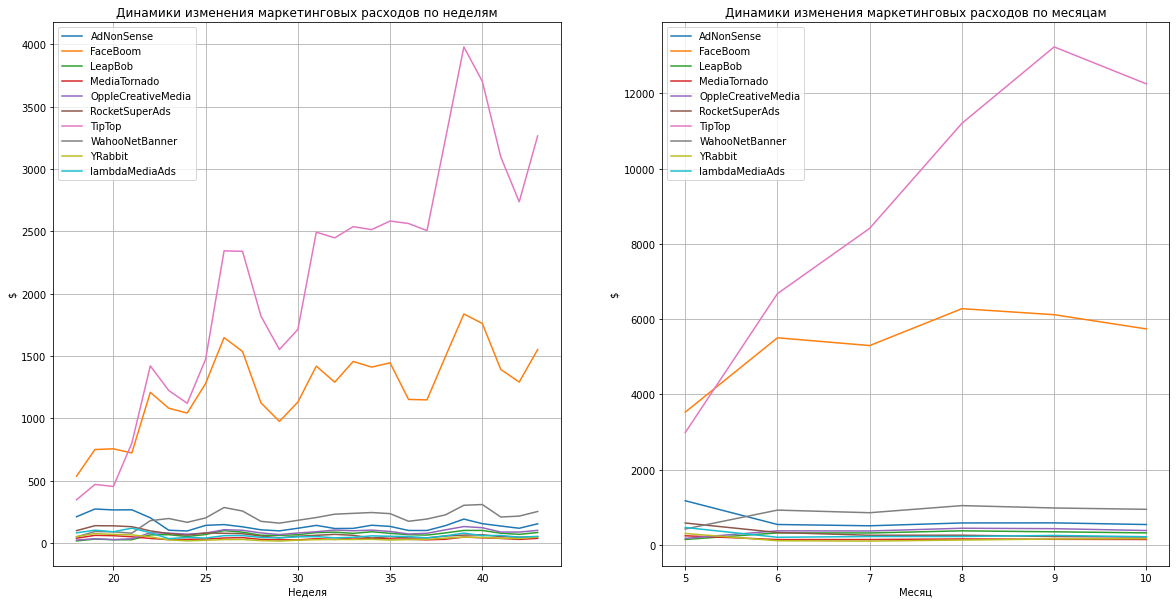

In [37]:
# создадим сводные таблицы с тратами по неделям и месяцам и построим по ним графики
costs_pivot_week = costs_grouped_week.pivot_table\
(index = 'week', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum')

costs_pivot_month = costs_grouped_month.pivot_table\
(index = 'month', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum')

plt.figure(figsize=(20, 10));

ax1 = plt.subplot(1, 2, 1)
costs_pivot_week.plot(grid = True, ax=ax1);
plt.legend()
plt.xlabel('Неделя')
plt.ylabel('$')
plt.title('Динамики изменения маркетинговых расходов по неделям');

ax2 = plt.subplot(1, 2, 2)
costs_pivot_month.plot(grid = True, ax=ax2);
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('$')
plt.title('Динамики изменения маркетинговых расходов по месяцам');

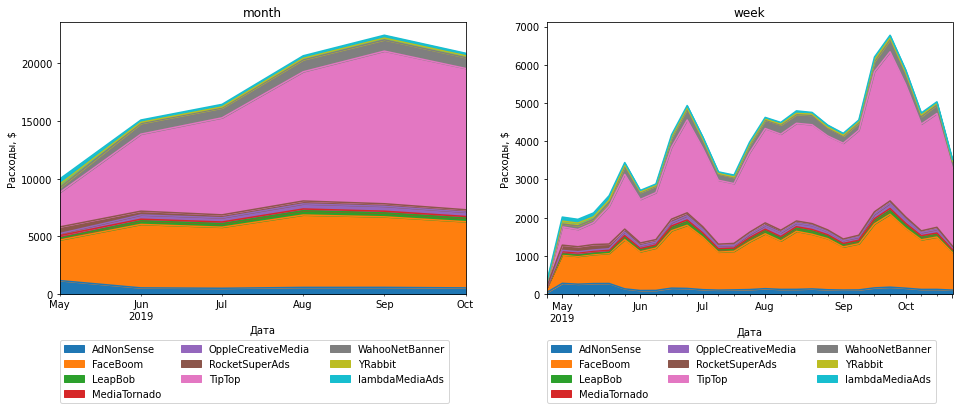

In [38]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week'] = costs['dt'].astype('datetime64[W]')

columns = ['month', 'week']

plt.subplots(figsize = (16, 5))
for i, col in enumerate(columns):
    costs.pivot_table(index = col, columns = 'channel', values = 'costs', 
                      aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')
    plt.legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left', borderaxespad=0)
plt.show()

In [39]:
all_costs_week = costs_grouped_week = profiles.groupby('week')\
.agg({'acquisition_cost':'sum'}).reset_index()

display(all_costs_week.head())

all_costs_month = costs_grouped_week = profiles.groupby('month')\
.agg({'acquisition_cost':'sum'}).reset_index()
all_costs_month

,week,acquisition_cost
0,18,1455.640
1,19,2031.820
2,20,1976.320
3,21,2297.120
4,22,3427.075


,month,acquisition_cost
0,5,9978.570
1,6,15090.045
2,7,16447.060
3,8,20657.870
4,9,22441.340
5,10,20882.415


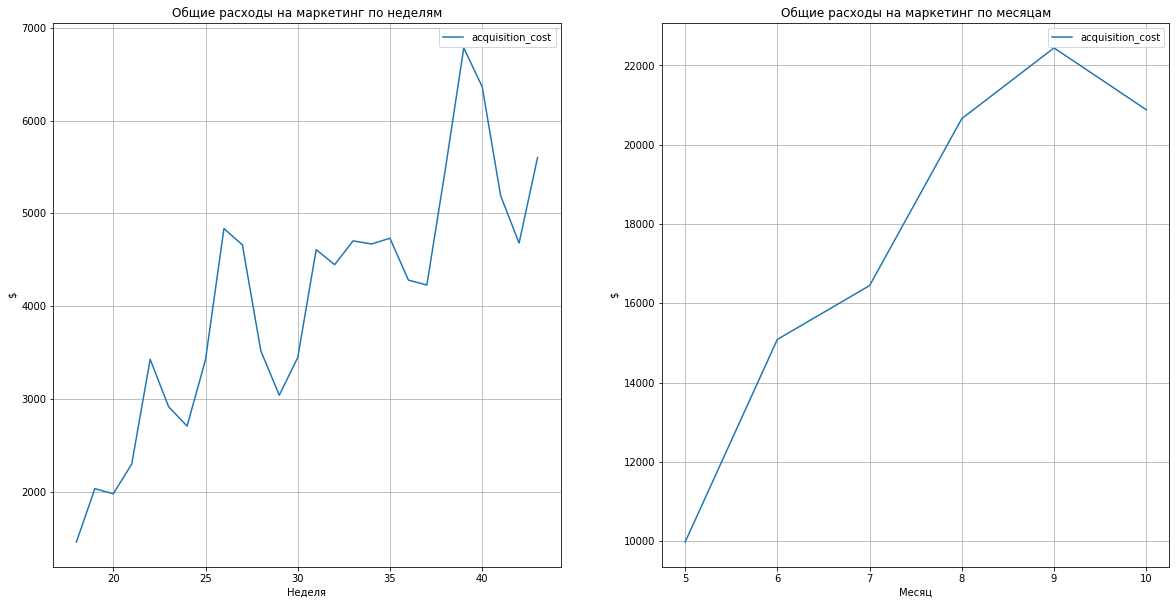

In [40]:
plt.figure(figsize=(20, 10));

ax1 = plt.subplot(1, 2, 1)
all_costs_week.plot(x='week', y ='acquisition_cost',grid = True, ax=ax1);
plt.legend()
plt.xlabel('Неделя')
plt.ylabel('$')
plt.title('Общие расходы на маркетинг по неделям');

ax2 = plt.subplot(1, 2, 2)
all_costs_month.plot(x='month', y ='acquisition_cost', grid = True, ax=ax2);
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('$')
plt.title('Общие расходы на маркетинг по месяцам');

- По графикам можно сделать вывод о том, что в мае в компании резко поменялась маркетинговая стратегия - решили значительно увеличить бюджет на продвижение в двух каналах FaceBoom и TipTop. 
- Причем акцент был сделан именно на сеть  TipTop: 
  - Если в начали мая затраты на рекламу в TipTop  были меньше, чем в FaceBoom, то к июню они возросли в двое (и уже превысили бюджет на FaceBoom), и дальше этот рост только усилился. 
  - К концу сентября на рекламу в TipTop  тратили уже в 4 с лишним раза больше, чем в мае.
  - Среднее увеличение рекламного бюджета на сеть FaceBoom к июню было примерно на 50%, в дальнейшем среднемесячный бюджет оставался на том же уровне.
- Траты на остальные осточники трафика практически не изменялись за весь период:
   - было небольшое перераспределение бюджета между двумя каналами: AdNonSense и WahooNetBanner
   
`Зацепка: резкое увеличие трат на рекламу в TipTop. Возможно, новая рекламная стратегия не оправдала себя и привлеченые пользователи не окупают себя`    

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [41]:
# сгрупируем профили пользователей по источнику 
# и расчитаем количество пользователей и суммарную затраты на рекламу
cac = profiles.groupby('channel').agg({'user_id': 'nunique', 'acquisition_cost': 'sum'})

# расчитаем сас
cac['cac'] = cac['acquisition_cost']/cac['user_id']
cac=cac.sort_values(by='cac', ascending=False).reset_index()
cac

,channel,user_id,acquisition_cost,cac
0,TipTop,19561,54751.30,2.799003
1,FaceBoom,29144,32445.60,1.113286
2,AdNonSense,3880,3911.25,1.008054
3,lambdaMediaAds,2149,1557.60,0.724802
4,WahooNetBanner,8553,5151.00,0.602245
5,RocketSuperAds,4448,1833.00,0.412095
6,OppleCreativeMedia,8605,2151.25,0.250000
7,YRabbit,4312,944.22,0.218975
8,MediaTornado,4364,954.48,0.218717
9,LeapBob,8553,1797.60,0.210172


Видим, что TipTop дает самых дорогих пользователей.

`И теперь надо понять: а окупают ли себя такие траты на привлечение?`

## 5. Оценим окупаемость рекламы

### Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 
Считаем, что сегодня календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

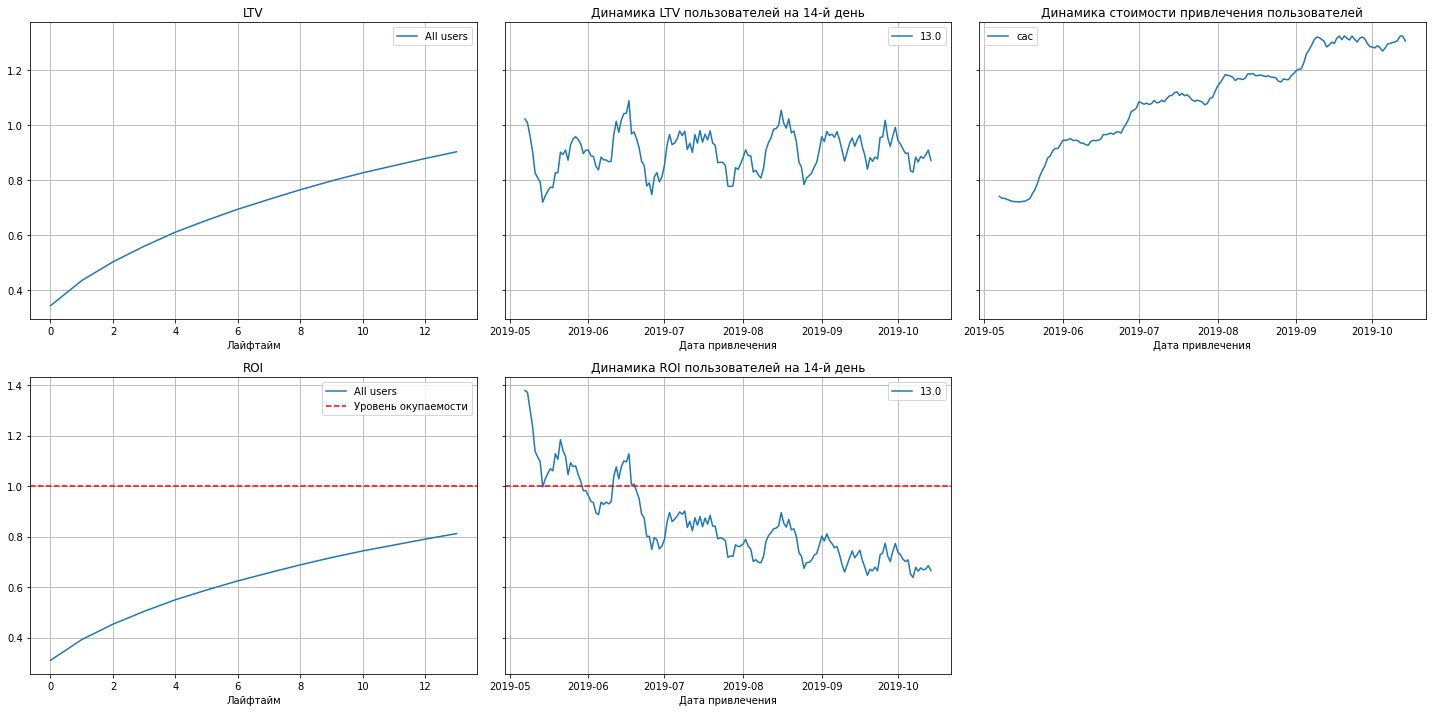

In [42]:
# зададим крайнюю дату и горизонт для анализа
observation_date = max_date
horizon_days = 14

# воспользуемся функциями для расчета LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = \
get_ltv(profiles, revenues, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


- в среднем доход от одного дользователя (LTV) 90 центов к 14 дню "жизни" относительно стабилен за весь период
- при этом средняя стоимость привлечения пользователя выросла до 1,3 доллара к осени
- затраты на рекламу не окупаются, ROI только-только достигает 80% к 14 дню
- окупаемость (ROI) резко снизилась в мае (по срокам этот период как раз совпадает со сменой рекламной стратегии) и дальше спад только усугубляется

`Вывод: наблюдается явная проблема с окупаемостью привлеченных пользователей. Затраты на привлечение только растут, а доход от клиентов не увеличивается. Остается разобраться в чем именно так проседает новая рекламная стратегия.`

### Проверьте конверсию пользователей и динамику её изменения и удержание

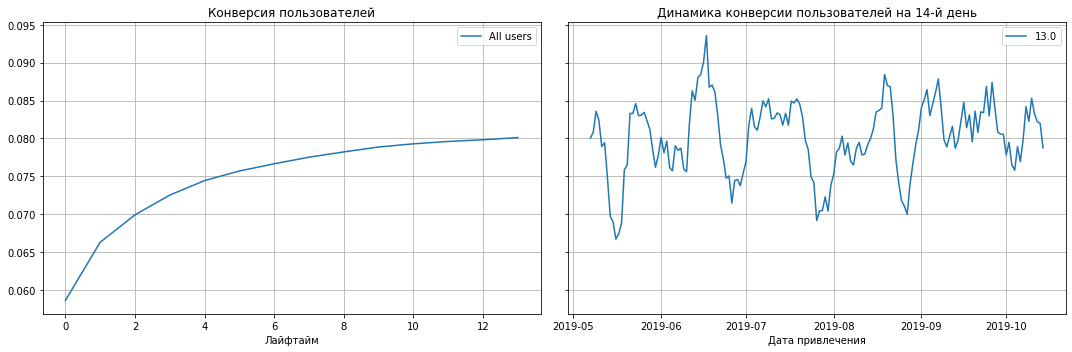

In [43]:
# успользуем ранее созданную функцию для расчета конверсии

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, revenues, observation_date, horizon_days, dimensions=[])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- графики конверсии выглядят реалистично, к концу второй недели конверсия около 8%
- есть небольшие колебания в течение календарного месяца, но в среднем этот показатель стабилен

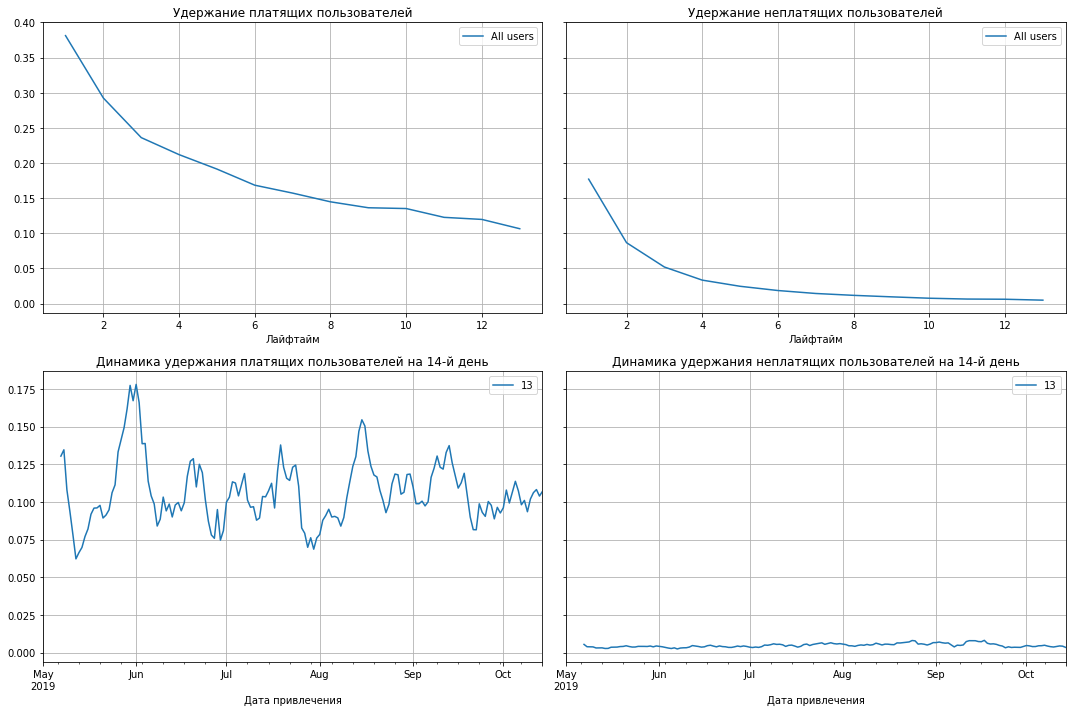

In [44]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, users, observation_date, horizon_days, dimensions=[])

plot_retention(retention_grouped, retention_history, horizon_days) 

- графики удержания напоминают гиперболу и удержание платящих пользователей выше, чем неплатящих, что говорит о реалистичности расчетов
- в среднем удержание за весь период достаточно стабильно

### Проанализируем окупаемость рекламы с разбивкой по устройствам. 

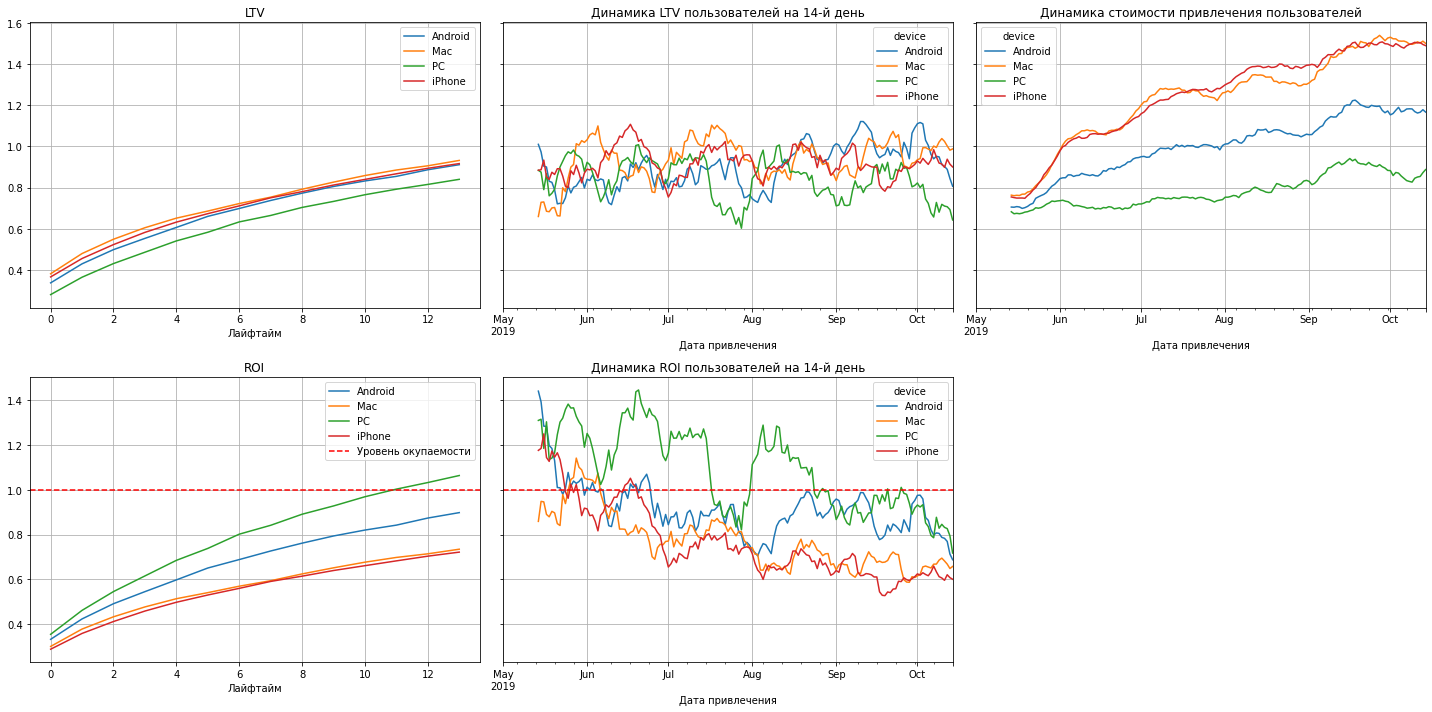

In [45]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenues, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


А вот тут уже видны просчеты в маркетинговой стратегии.
- LTV пользователей с iPhone, Mac, Android приблизительно одинаковы и стабильны за весь период, LTV для PC немного ниже, НО затраты на привлечение пользователей очень разняться в зависимости от устройства.
- с мая по октябрь стоимость "яблочного" пользователя выросла в 2 с лишним раза, цена пользователя с Android в 2 раза, только пользователи с РС стали немного дороже
- а начале мая за две недели пользователи с iPhone, PC, Android окупались (ROI>1), только пользователи с Мас немного не дотягивали до окупаемости в ноль
- с июня динамика ROI для iPhone, Mac, Android идет вниз, затраты на привлечение перестали окупаться для всех девайсов (PC держался до конца лета). 
- Двухкратное увеличение цены нового пользователя при неизменном доходе LTV, снизили окупаемость до 60-70%  по всем утсройствам

### Проанализируем окупаемость рекламы с разбивкой по странам.

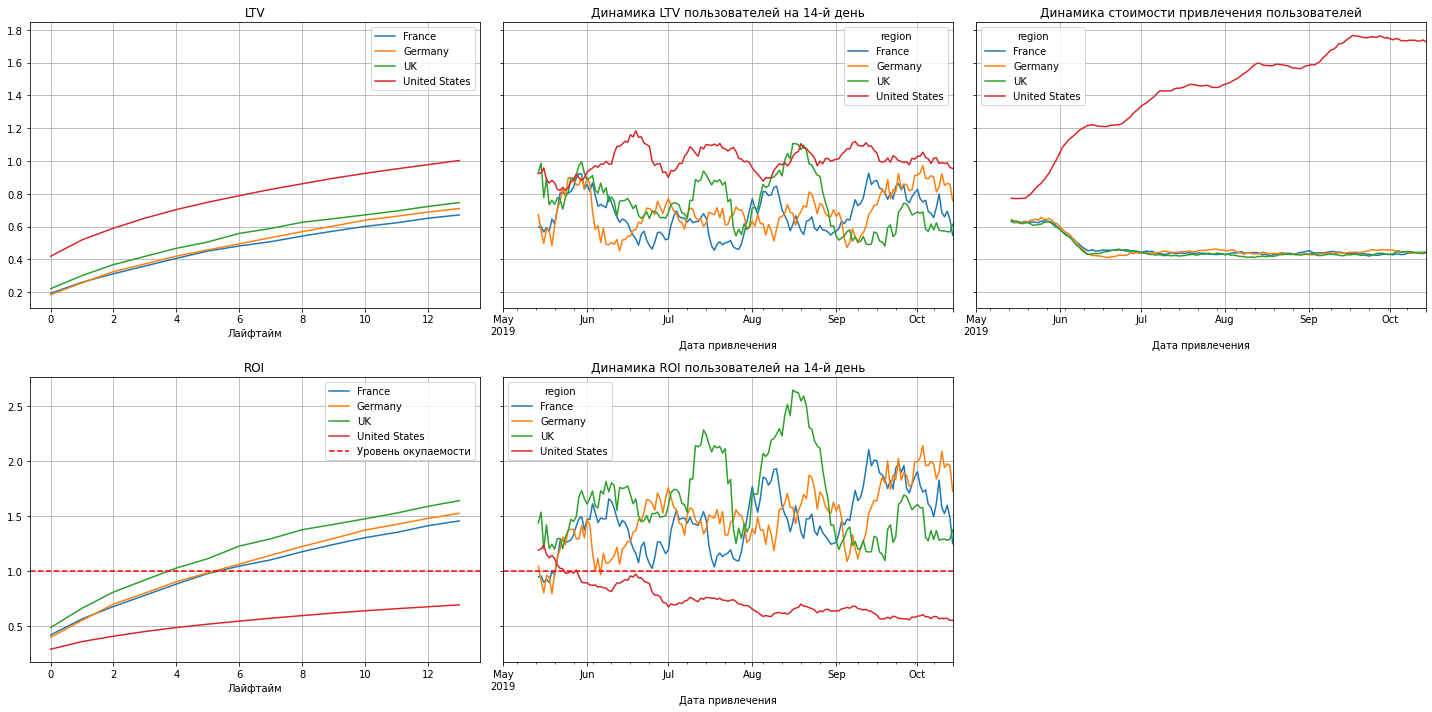

In [46]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenues, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- опять видим достаточно стабильный LTV за весь период. Конечно, пользователи из США приносят больше денег компании, но как мы помним их намного больше, чем европейцев
- LTV во всех европейских странах держится примерно на одном уровне
- стоимость европейского пользователя снизилась на 30%, а вот привлечение одного американца компания платит в 2,2 раза больше, чем в мае.
- ROI для европейских стран неплохой, уже к 6 дню за затраты на привлечение окупаются (англичане окупаются даже на 4й день)


Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

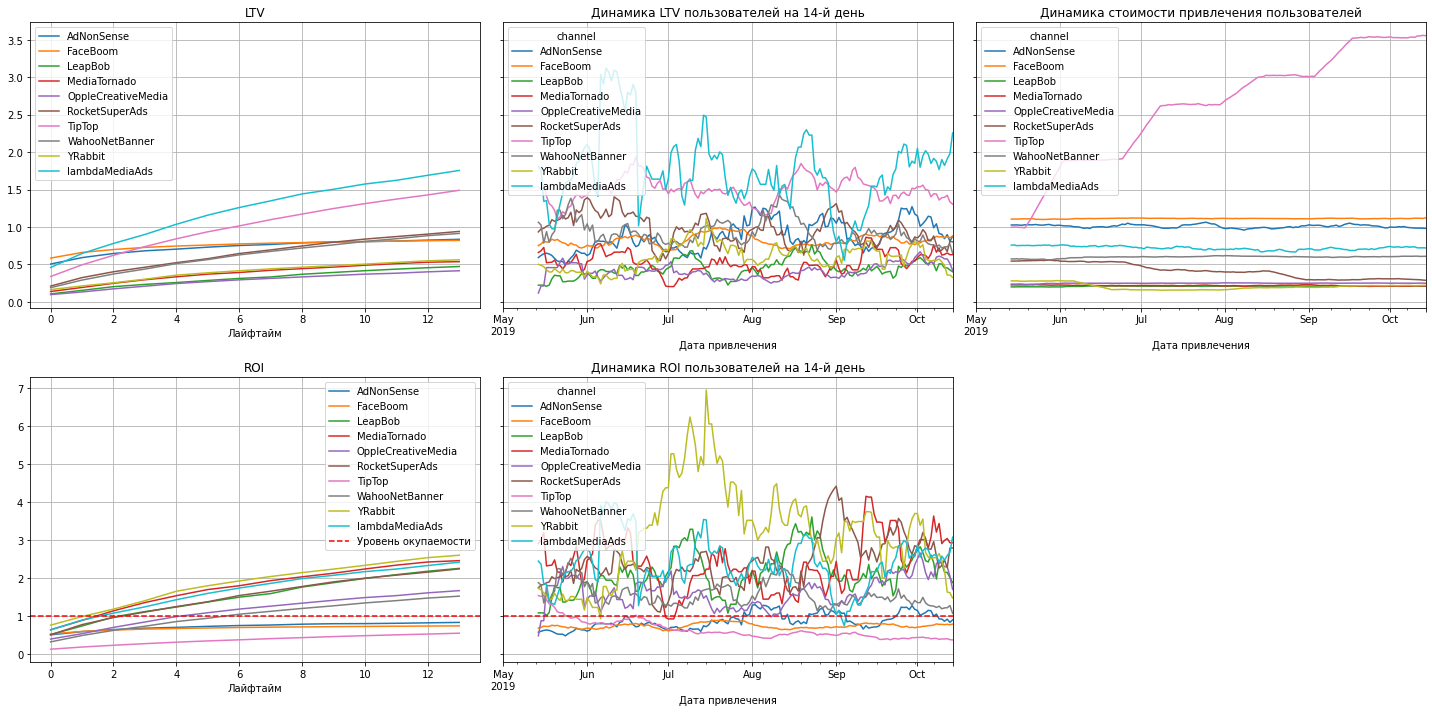

In [47]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenues, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- каждый новый пользователь не стал приносить больше денег, динамика LTV в среднем за весь период стабильная
- LTV пользователей привлеченных из TipTop и LambdaMediaAds немного выше остальных, но так было и до изменения маркетинговой стратегии
- САС пользователей из TipTop сремительно рос от месяца к месяцу (к октябрю 1 пользователь из TipTop стал дороже в 3,5 раза), САС по остальным каналам оставался неизменным за весь период
- больше остальных компания зарабатывает на пользователе пришедшем из LambdaMediaAds. Затраты на привлечение одного такого пользователя окупаются уже на второй день
- есть только три неокупающих себя источника: TipTop, FaceBoom, AdNonSense. А если вспомнить траты на маркетинг по каналам (см. код ниже), то на эти ресурсы приходится более 90% всего рекламного бюджета - поэтому неудивительно, что компания терпит убытки не смотря на огромные рекламные бюджеты

In [48]:
# вспомним рекламные траты по каналам
costs_grouped

,channel,acquisition_cost
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


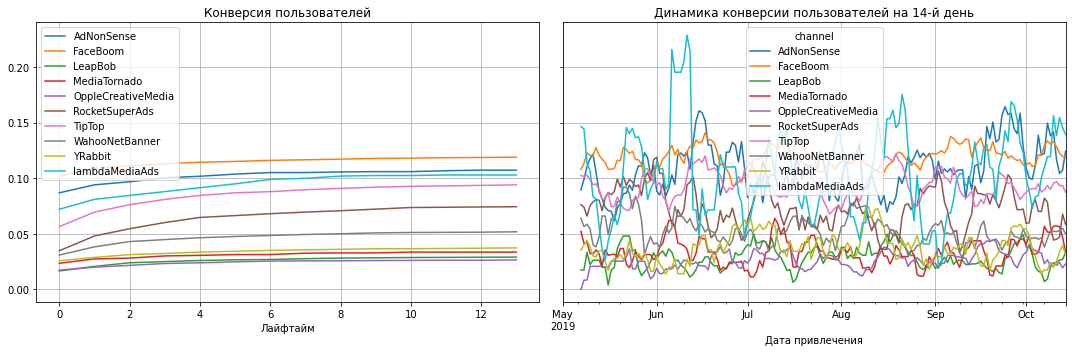

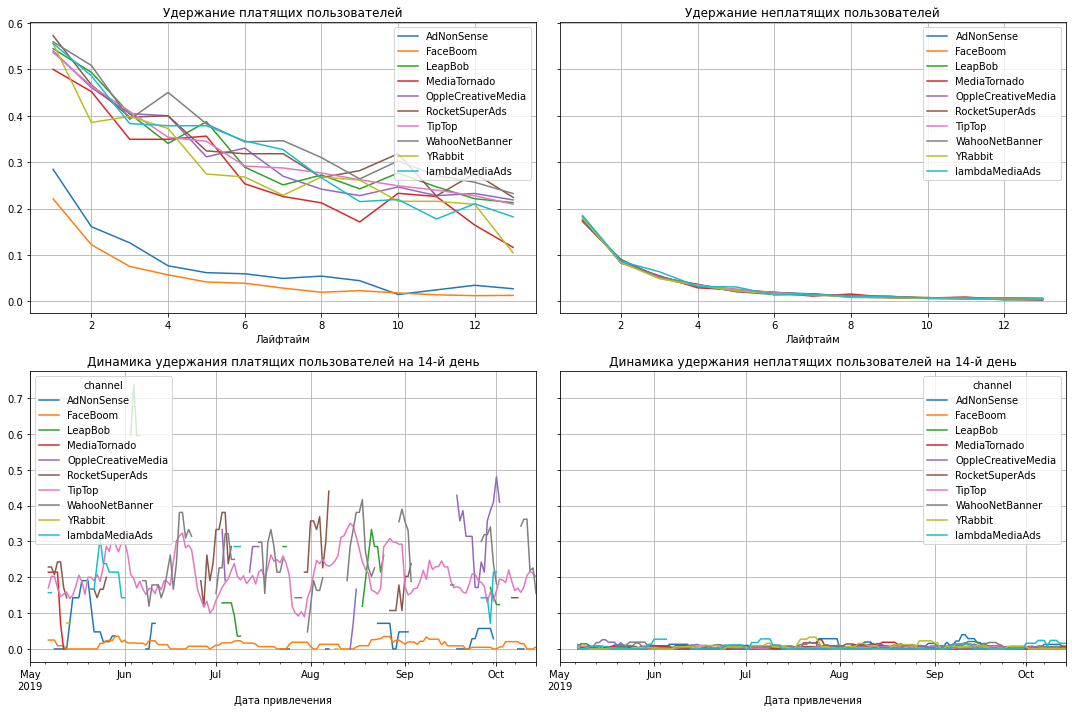

In [49]:
# cначала сгруппируем пользователей по каналу привлечения

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = \
get_conversion(profiles, revenues, observation_date, horizon_days, dimensions=dimensions,\
    ignore_horizon=False,
)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, users, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days) 

- явно есть проблема с удержанием платящих пользователей в двух каналах: FaceBoom и  AdNonSense. 
-  конверсия у этих каналов даже повыше, чем у остальных, но удержание совсем слабое - почти на уровне неплатящих пользователей. `Необходимо определить причины такого низкого удержания и понять как его можно увеличить до уровня остальных каналов`


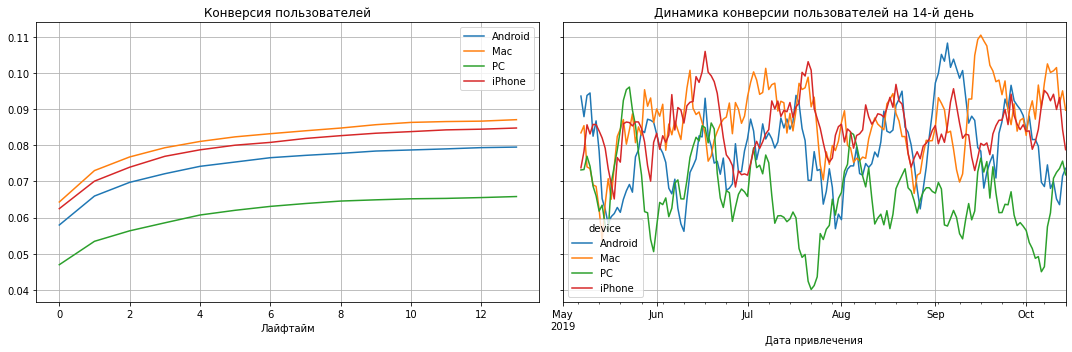

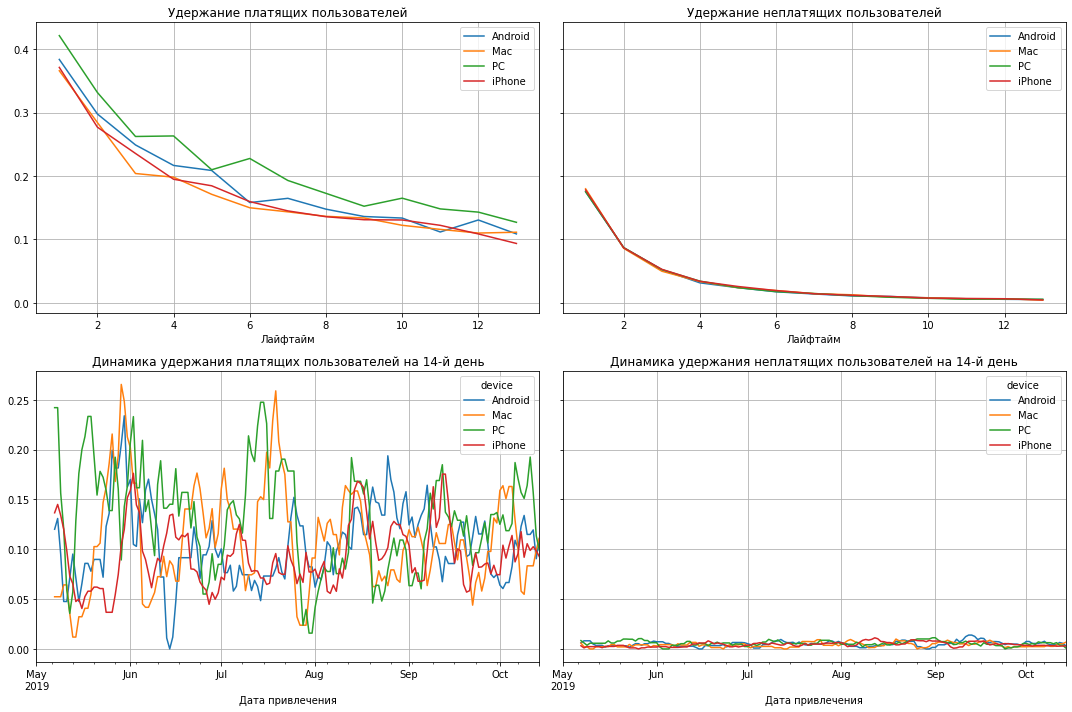

In [50]:
#  далее по устройству
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, revenues,\
    observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,
)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, users, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days) 

- удержание платящих пользователей, примерно, на всех устройствх похожи (чуть лучше для пользователей РС)
- а вот конверсия пользователей РС ниже остальных

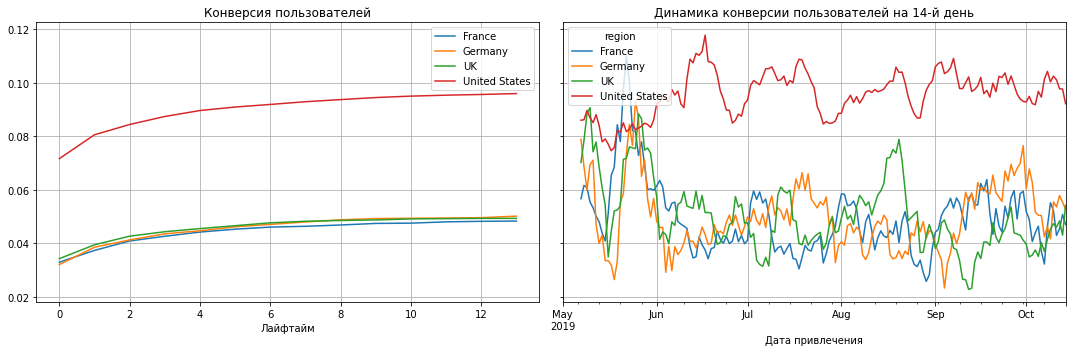

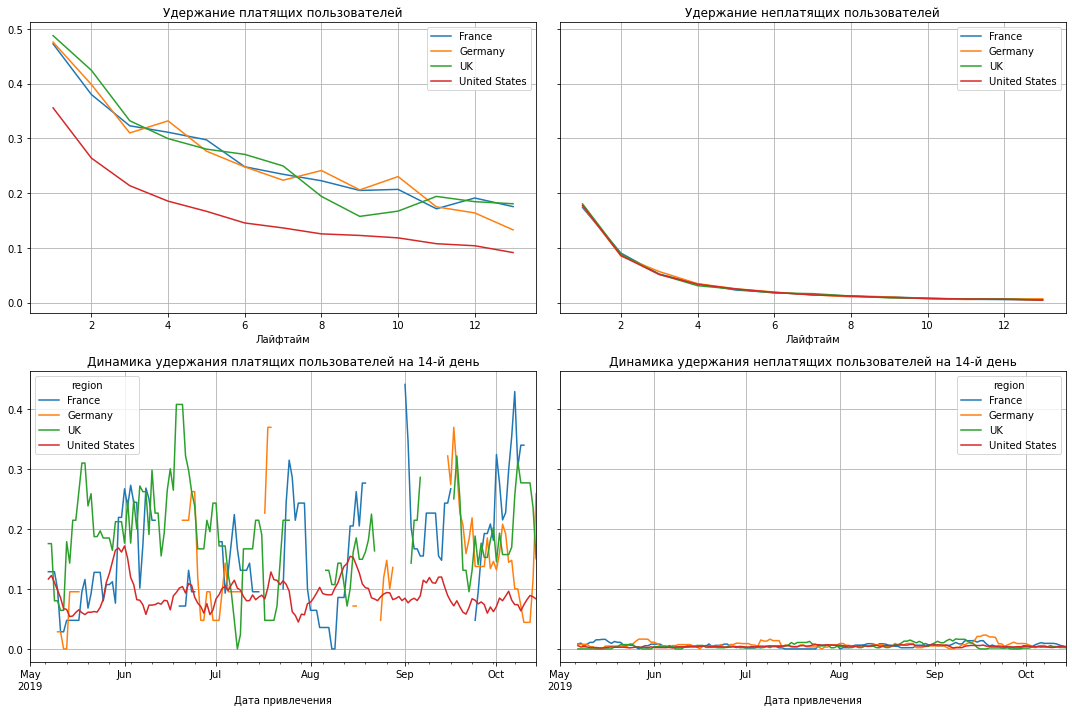

In [51]:
# и по стране

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, revenues, \
                               observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False)

retention_raw, retention_grouped, retention_history = get_retention(profiles, users, observation_date, \
                                                                    horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days) 

- конверсия платящих пользователей в Америки выше европейских стран, но удержание низкое
- в Европейский странах конверсия и удержание похожи во всех странах

### Разобьем пользователей на группы (Америка и Европа) и исследуем конверсию и удержание для каждой когорты

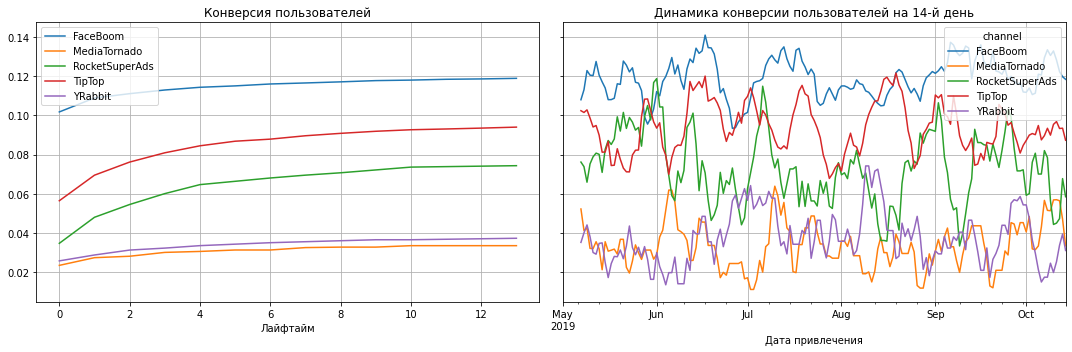

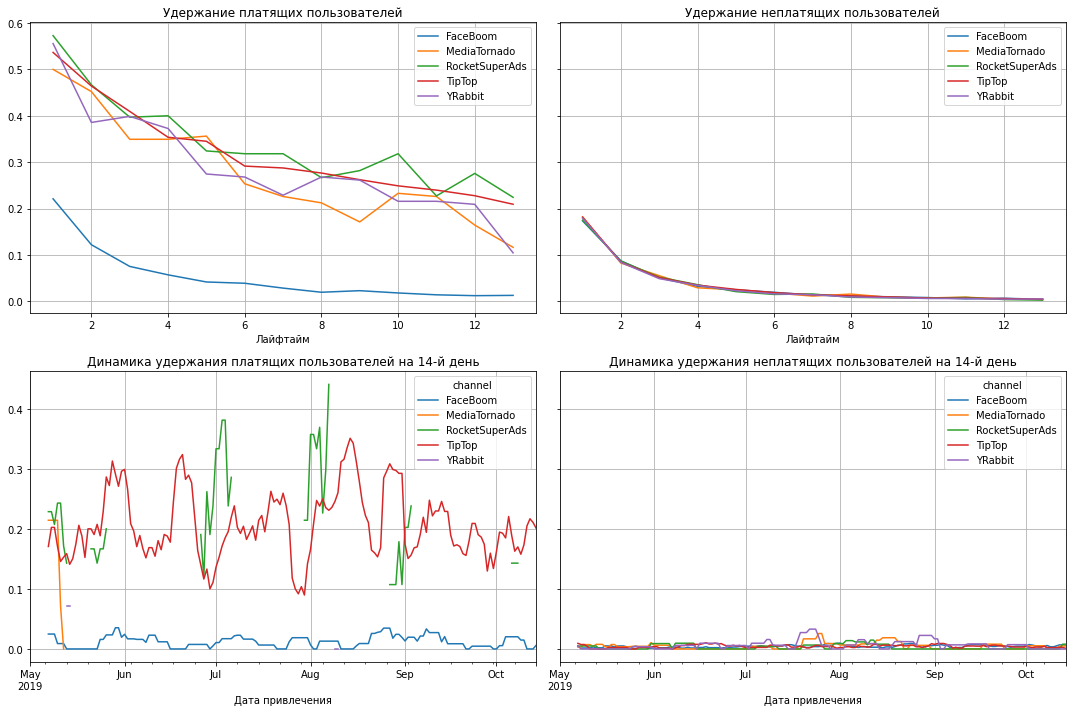

In [52]:
# выделем пользователей только из Америки
profiles_usa = profiles.query('region == "United States"')
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_usa, revenues, \
                               observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False)

retention_raw, retention_grouped, retention_history = get_retention(profiles_usa, users, observation_date, \
                                                                    horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days) 

- в Штатах конверсия платящих пользователей выше всего в FaceBoom, но удержание на уровне неплатящих. То есть пользователи реагируют на рекламу, но дальше приложение не используют. Явно какая-то проблема с настройкой рекламы или технического характера, так как у других источников удержание на порядок выше


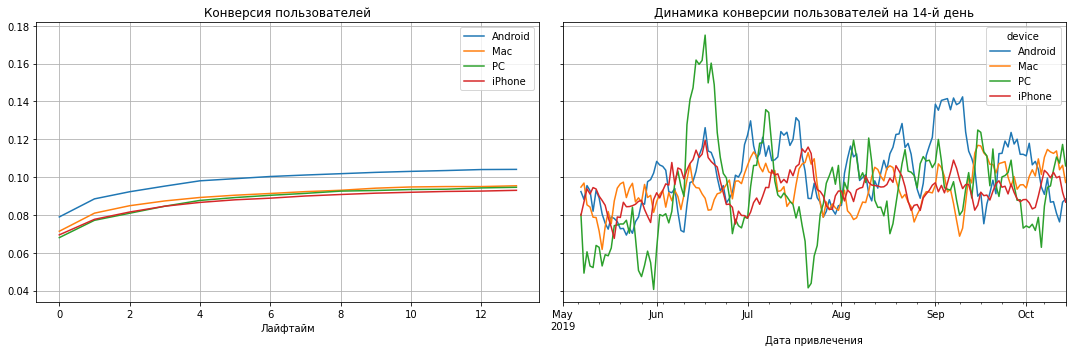

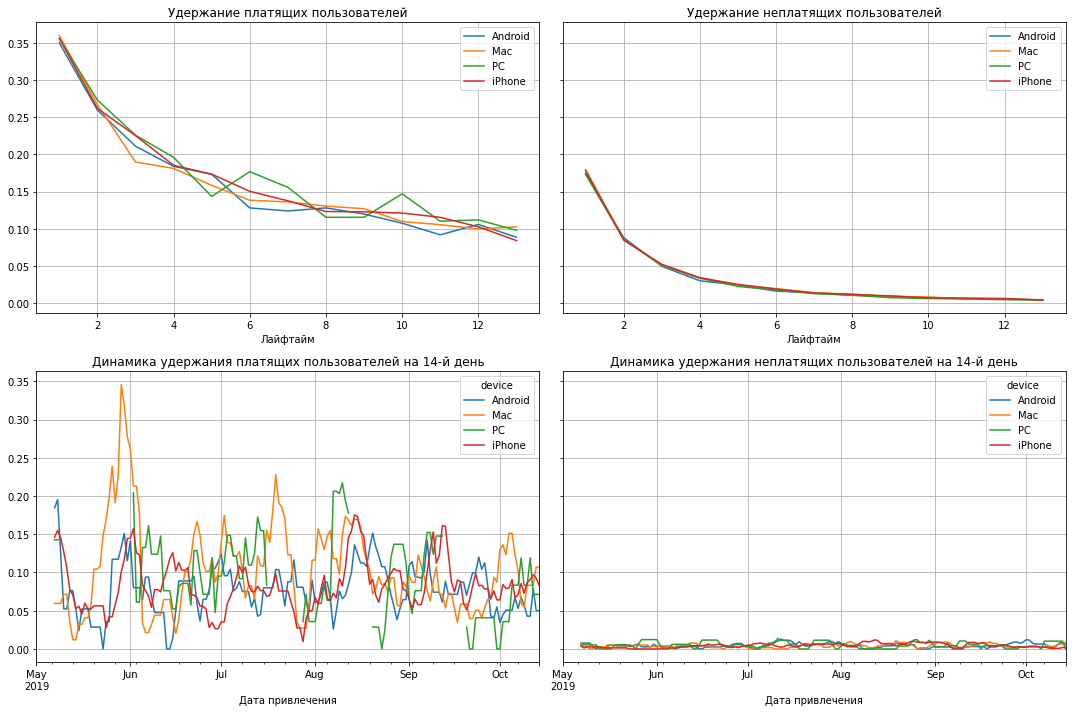

In [53]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_usa, revenues, \
                               observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False)

retention_raw, retention_grouped, retention_history = get_retention(profiles_usa, users, observation_date, \
                                                                    horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days) 

- в Америке чуть выше конверсия для  Android, но удержание одинаково. Здесь проблем нет

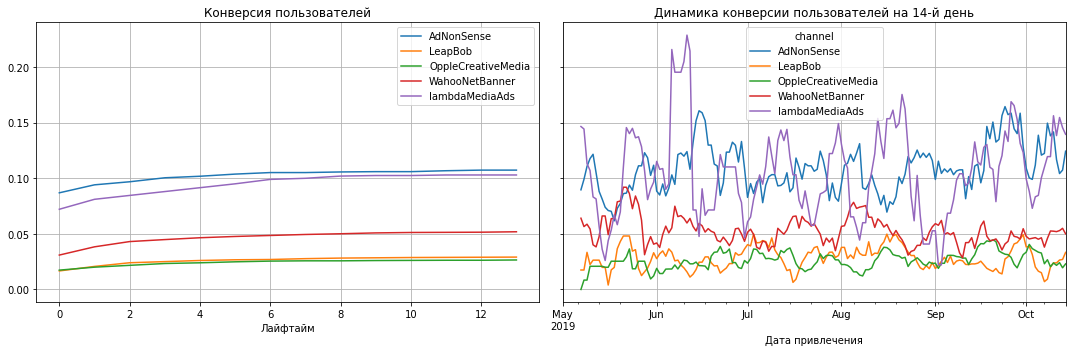

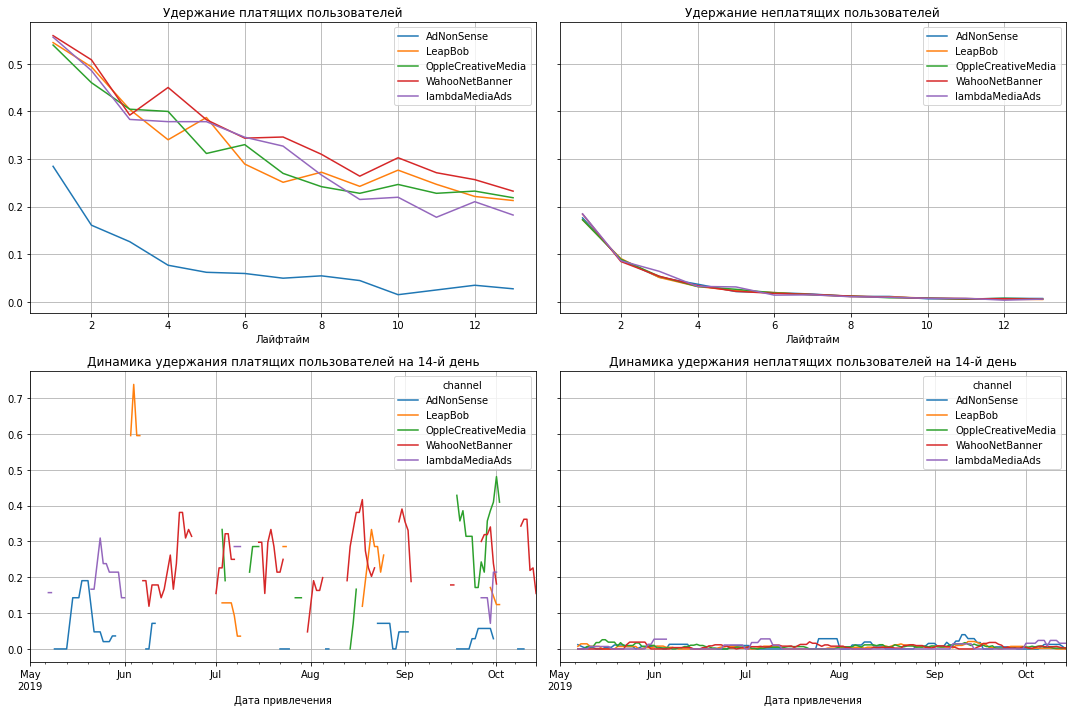

In [54]:
# выделим профили европейцев
profiles_europe= profiles.query('region !="United States"')
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_europe, revenues, \
                               observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False)

retention_raw, retention_grouped, retention_history = get_retention(profiles_europe, users, observation_date, \
                                                                    horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days) 

 - есть два канала с самой высокой конверсией: AdNonSense, lambdaMediaAds
 - но пользователи из AdNonSense очень слабо удерживаются
 - в Европе совсем незадействованы каналы FaceBoom и TipTop, которые популярны в Америке 
 - `Необходимо понять используют ли их в Европе?  Стоит ли там рекламироваться?`

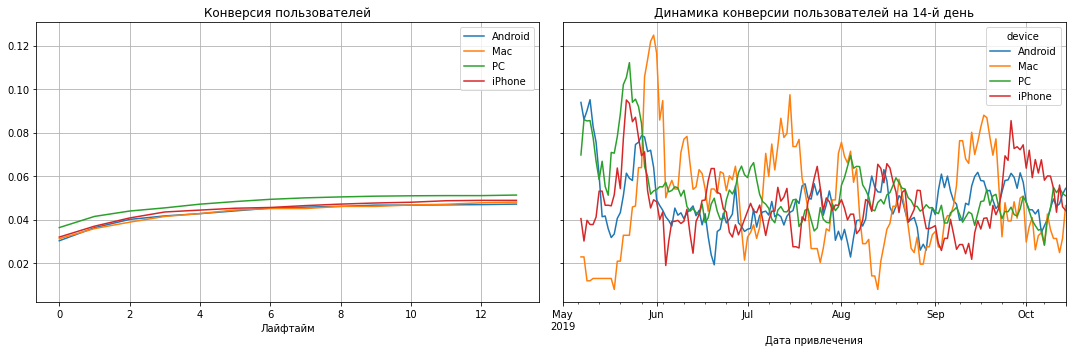

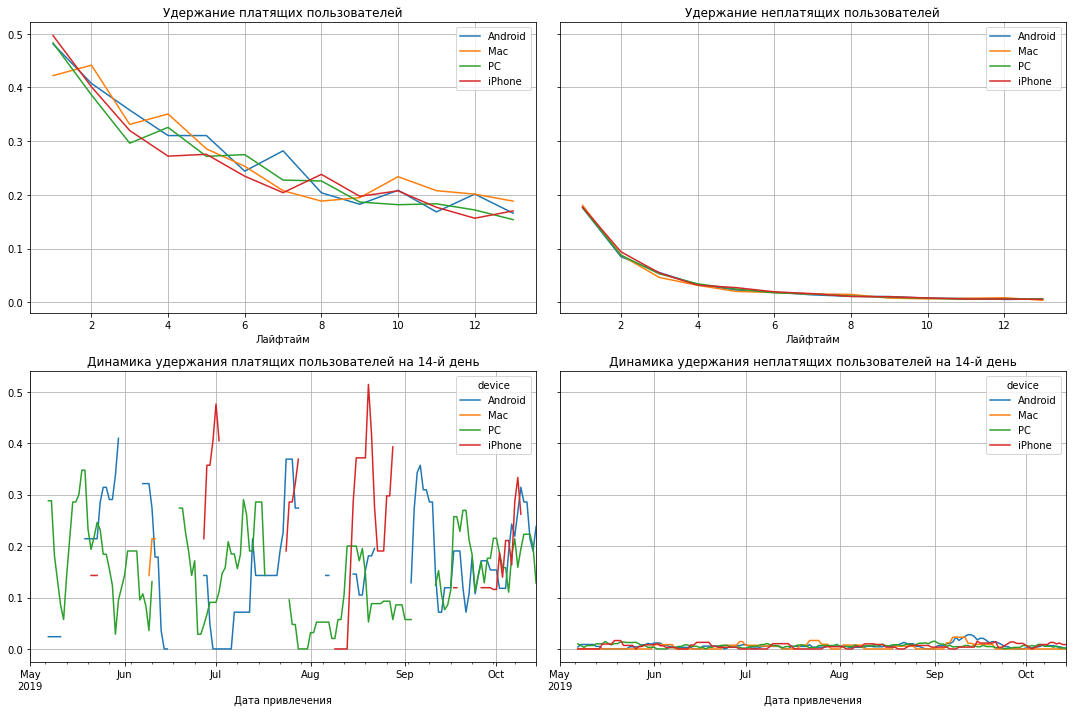

In [55]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_europe, revenues, \
                               observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False)

retention_raw, retention_grouped, retention_history = get_retention(profiles_europe, users, observation_date, \
                                                                    horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=7)

plot_retention(retention_grouped, retention_history, horizon_days)

- конверсия и удержания примерно одинаковы на всех устройствах европейцев

# Выводы:

### Качество входных данных и предварительная обработка:
- данные для анализа были качественными. Отсутствовали пропуски и дубликаты, имена полей и хранимые значения легко понять
- были переименованы названия полей в столбцах  - преведены к общепринятому стилю snake_case. `Администраторам базы данных стоит перевести все поля к этому стандартному виду` 
- поля, хранящие значения даты и времени были преобразованы в тип datetime

### Общие выводы по проекту:
- в мае ввели новую маркетинговую стратегию, как оказалась неэффективную. 
- большинство клиентов живут в Америке и узнают о нашем приложении через сети TipTop и FaceBoom.
- основное маркетинговое нововведение мая: с каждым месяцем все больше и больше денег вкладывали в привлечение клиентов из Америки через сеть TipTop, потратили на это болше половины общего бюджета, но ожидаемого результата это не дало. Росла стоимость одного пользователя, но его LTV отставалась приблизительно на том же уровне
- траты на продвижение в других источниках сильно не увеличивались
- не смотря на снижение трат на привлечение пользователей из Европы их LTV остался примерно на прежнем уровне, что соответственно повысило ROI для этих стран - значит можно эффективнее окупать рекламу не раздувая при этом бюджет
- чаще пользователи заходят в наше приложение через мобильный телефон, но есть и те, кто предпочитает компьютер.
- пользователи Мас совершают покупки охотнее других, возможно, там удобнее интерфейс или выше устойшивость к ошибкам

### Рекомендации:
- так как пользователей из Америки больше остальных, и сети TipTop и FaceBoom дают наибольший прирост пользователей, то, конечно, было логично сделать на них упор в рекламе. Но стоит более осторожно вводить нововведения, оценивая эффективность очередного шага каждые 7-14 дней и оперативно корректировать стратегию.
- необходимо проанализировать какие источники (блоггеры, каналы и тд) были задействованы за этот период в TipTop. Какие из них дали ожидаемый прирост, а какие провалились и почему. Далее оставлять только успешные форматы рекламы, от неэффективных сразу отказываться и заменять их более подходящими (то же относится и к сети FaceBoom и тп).
- дать задание тестировщикам протестировать приложение на разных устройствах, выяснить есть ли какие-то различия в интерфейсе, удобстве использования, понятности, отсутствию багов и тд. Помним, что пользователей с мобильными больше, поэтому стоит в перую очередь протестировать мобильную версию приложения.
- проанализировать какие методы продвижения есть для стран Европы, какие там используются методы продвижения и тд, ведь даже при снижении рекламного бюджета, LTV европейцев не упал и реклама стала окупаться даже эффективнее - может получится добиться такого для Америки?
- и еще раз: стоит на каждом шагу анализировать все новые маркетинговые изменения, понимая что именно увеличивает доход компании, а что тоько съедает рекламный бюджет.



 
Дополнительные выводы:
    
  - проблема для Америки: 
       - самые эффективные каналы привлечения TipTop и FaceBoom. Имменно через них больше всего приходит новых пользователей. Но оба эти канала работают плохо.
       - платящие пользователи из сети FaceBoom хорошо реагируют на рекламу (конверсия высокая), но совсем не удерживаются        (удержание по этому каналу на уровне неплатящих). Необхлдимо дополнительно исследовать причины такого слабого удержания
       - платящие пользователи из сети TipTop хорошо реагируют на рекламу и неплохо удерживаются, но они слишком дорогие и в итоге реклама в этом канале не окупает себя
    
    
  - Проблемы в Европе:
       - в Европе слабое удержание через пользователей пришедших через канал AdNonSense, при высокой конверсии удержание самое низкое (близкое к неплатящим)
       - в Европе совсем не задействованы сети TipTop и FaceBoom, которые в Америки дают больше всего новых пользователей, надо понять, можно ли их добавить к каналам продвижения для Европейцев.
        
    
 Итог: получается вкладывая все больше и больше денег в рекламу через сети TipTop и FaceBoom, компания только теряла деньги, ведь оба эти самые крупные иточника привлечения были неэффективные.
    
